In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import cartopy.crs as ccrs
#import h5py
import pandas as pd
import numpy as np
from cartopy.feature.nightshade import Nightshade
from IPython.display import Video
import matplotlib.animation as animation
from cartopy.io.img_tiles import OSM
import cartopy.io.img_tiles as cimgt
from matplotlib.tri import Triangulation, UniformTriRefiner
import os
from pandas import Timestamp
from scipy.signal import stft, spectrogram
import scipy.fftpack
from datetime import timedelta
import pycwt as wavelet

In [7]:
#functions
def get_df(start, end, extent, files):
    df = pd.read_pickle(files[0])
    df = df.where(df.datetime > start)#filter by time
    df = df.where((df.gdlat > extent[0]) & (df.gdlat < extent[1]))#filter by lat
    df = df.where((df.glon > extent[2]) & (df.glon < extent[3])).dropna()#filter by lon



                
    return df
    
def getmag():
    #get single dataframe of all mags
    mag = pd.DataFrame()
    for file in os.listdir(os.getcwd()):
        if file.endswith('.sec'):
            data = pd.DataFrame()
            df = pd.read_csv(file,skiprows=20, sep='\\s+')
            data['datetime'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
            data['H'] = df.iloc[:,[3]]
            data['D'] = df.iloc[:,[4]]
            data['Z'] = df.iloc[:,[5]]
            data['F'] = df.iloc[:,[6]]
            data['station'] = file[0:3]
            mag = pd.concat([mag, data])
    stations = pd.DataFrame({"code" : ['bou', 'frd', 'frn'], "lat" : [40.137, 38.205, 37.091], "lon" : [-105.236, -77.383, -119.718]})
    return mag, stations

def tec_slice(df, extent, start, end):
    df = df.where((df.datetime > start) & (df.datetime < end))
    df = df.where((df.gdlat > extent[0]) & (df.gdlat < extent[1]))
    df = df.where((df.glon > extent[2]) &(df.glon < extent[3])).dropna()
    return df

def plot_setup(tec, mag, stations, code, tec_size, start, end):
    lat = 48
    lon = -106
    latlon = [lat, lon]
    print(lat, lon)
    extent = [lat - tec_size, lat + tec_size, lon - tec_size, lon + tec_size]
    slice_tec = tec_slice(tec, extent, start, end)

    
    slice_mag = mag[mag['station'] == code]
    slice_mag = slice_mag.where((slice_mag.datetime > start) & (slice_mag.datetime < end)).dropna()
    slice_mag['detrend_H'] = slice_mag.H - slice_mag.rolling(7200, center=True, min_periods=1).mean().H
    slice_mag['detrend_D'] = slice_mag.D - slice_mag.rolling(7200, center=True, min_periods=1).mean().D
    return slice_tec, slice_mag, latlon

In [32]:
#variables
del dt
import datetime as dt
start = dt.datetime(2017, 9, 8)
end = dt.datetime(2017, 9, 8, 4)
plot_start = dt.datetime(2017, 9, 8)
plot_end = dt.datetime(2017, 9, 8, 2)
files = ['los_20170908.pkl']
extent = [20, 70, -130, -60]#geographic extent of measurments, [lat_min, lat_max, lon_min, lon_max], helps reduce size of df
code = 'frn' #magnetometer station
tec_size = 0.5 #1/2 of degrees in lat, lon of measurment window to consider TEC measurments "above" magnetometer

In [33]:
#load in all available tec and mag data within extent constant
mag, stations = getmag()
tec = get_df(start, end, extent, files)

In [34]:
#setup individual plots, run only this when switching between stations
plot_tec, plot_mag, latlon = plot_setup(tec, mag, stations, code, tec_size, start, end)


48 -106


In [26]:

lat = 48
lon = -106
extent = [lat - tec_size, lat + tec_size, lon - tec_size, lon + tec_size]
slice_tec = tec_slice(tec, extent, start, end)

In [27]:
print(slice_tec.head())

          gdlat    glon    tec  dtec    elm            datetime
18004470  47.99 -105.62  12.02  0.97  20.99 2017-09-08 02:00:30
18031773  48.46 -105.71   7.58  0.13   9.43 2017-09-08 02:00:30
18031864  48.00 -105.67   7.07  0.11   8.53 2017-09-08 02:00:30
18032008  47.63 -106.17   7.07  0.08   8.55 2017-09-08 02:00:30
18032095  48.31 -106.07   7.27  0.12   9.66 2017-09-08 02:00:30


Text(0.5, 1.0, 'TEC Measurments within +- 0.5 degrees of 48, -106')

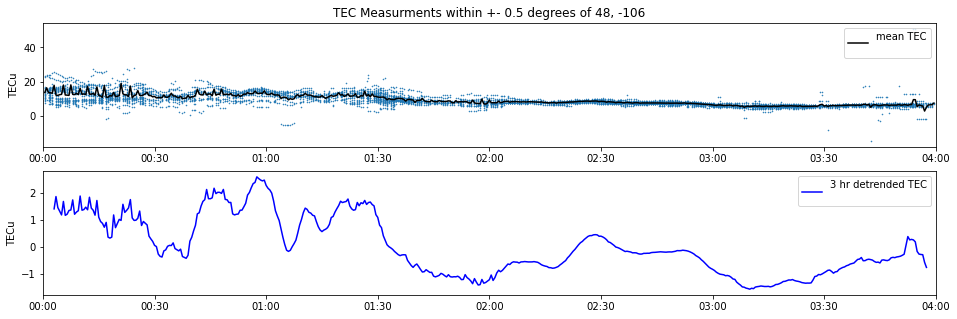

In [39]:
#setup plotting
fig, ax = plt.subplots(2, 1, figsize=(16,5))

import matplotlib.dates as mdates
#tec plotting on left y axis
ax[0].scatter(plot_tec.datetime, plot_tec.tec, s=.3)
grouped = plot_tec.set_index('datetime').groupby(pd.Grouper(freq='s')).mean().dropna()
detrend = grouped.tec - grouped.rolling(360, center=True, min_periods=1).mean().tec
ax[0].plot(grouped.index, grouped.tec, label='mean TEC\n', c='k')
ax[1].plot(detrend.rolling(10, center=True).mean(), label='3 hr detrended TEC\n', c='b')
ax[0].set_xlim([start, end])
ax[1].set_xlim([start, end])
ax[0].set_ylabel('TECu')
ax[1].set_ylabel('TECu')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
#plt.set_ylim([-5, 5])

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_title('TEC Measurments within +- ' + str(tec_size) + ' degrees of '  + str(latlon[0]) + ', ' + str(latlon[1]))


In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(16,5))
ax[0].set_title("BOU Magnetometer Data")
ax[0].plot(plot_mag.datetime, plot_mag.H - plot_mag.H.mean(), Label = 'H')
ax[0].plot(plot_mag.datetime, plot_mag.Z - plot_mag.Z.mean(), Label = 'Z')
ax[0].legend(loc='upper right')
ax[1].plot(plot_mag.datetime, plot_mag.detrend_H, c='r', Label = 'Detrended H')
ax[1].legend(loc='upper right')
ax[1].set_ylim([-75, 75])
ax[0].set_ylim([-75, 75])
ax[0].set_xlim([start, end])
ax[1].set_xlim([start, end])
ax[0].set_ylabel('nT')
ax[1].set_ylabel('nT')

In [ ]:
#setup plotting
fig, ax = plt.subplots(figsize=(16,3))
axes = [ax, ax.twinx()]


#tec plotting on left y axis
grouped = plot_tec.set_index('datetime').groupby(pd.Grouper(freq='s')).mean().dropna()
detrend = grouped.tec - grouped.rolling(240, center=True, min_periods=1).mean().tec

axes[0].plot(detrend.rolling(10, center=True).mean(), label='2 hr detrended TEC\n', c='b')
axes[0].set_ylabel('TECu')
axes[0].legend(loc='upper left')
axes[0].set_ylim([-5, 5])

#mag plotting on right y axis
axes[1].plot(plot_mag.datetime, plot_mag.detrend_H, label='2 hr detrended ' + str(code) + '_H', c='r')

axes[1].legend(loc='upper right')
axes[1].set_ylabel('nT')
axes[1].set_ylim([-75, 75])
plt.xlim([start, end])

plt.title('TEC Measurments within +- ' + str(tec_size) + ' degrees of ' + str(code) + ' magnetometer\nlocated at ' + str(latlon[0]) + ', ' + str(latlon[1]))





In [ ]:
grouped = plot_tec.set_index('datetime').groupby(pd.Grouper(freq='s')).mean().dropna()
detrend = grouped.tec - grouped.rolling(240, center=True, min_periods=1).mean().tec

grouped1 = plot_mag.set_index('datetime').groupby(pd.Grouper(freq='s')).mean().dropna()
detrend1 = grouped1.H - grouped1.rolling(7200, center=True, min_periods=1).mean().H

lags = []
p_vals = []
for i in range(-10000,10000):
    p_vals.append(detrend.corr(detrend1.shift(i)))
    lags.append(i)

print(min(p_vals), max(p_vals))
for j in range(-1000,1000):
    if p_vals[j] == min(p_vals):
        print(j)
print(detrend.corr(detrend1))


In [ ]:

fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(10,8))

Dt = 1

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(plot_mag.detrend_H.values, Dt)

power = (np.abs(wave)) ** 2
period = 1 / freqs

power /= scales[:, None]

mesh = axs[0].pcolormesh(plot_mag.datetime, period / 60, power)

axs[0].set_ylabel('period, minutes')
axs[0].set_title(str(code) + ' magnetometer H component wavelet coherence')



dt = 30

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(detrend.rolling(10, center=True).mean().dropna().values, dt)
power = (np.abs(wave)) ** 2
period = 1 / freqs
power /= scales[:, None]

mesh = axs[1].pcolormesh(detrend.rolling(10, center=True).mean().dropna().index, period / 60, power)

axs[1].set_ylabel('period, minutes')
axs[1].set_title(str(code) + ' TEC wavelet coherence')

axs[1].set_ylim([0,240])
axs[0].set_ylim([0,240])
axs[0].set_xlim([start, end])
axs[1].set_xlim([start, end])

In [ ]:
resolution = 1
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,12))

f, t, Zxx = stft(plot_mag.detrend_H.dropna(), fs=1/resolution, nperseg=7200, noverlap=6840)
Zxx = Zxx **2
times = []
for sample in t:
    times.append(start + timedelta(seconds = sample / resolution))
mesh1 = ax0.pcolormesh(times, f*1000, np.abs(Zxx), vmin=0,vmax=200)
#ax0.set_xlim([plot_start, plot_end])
ax0.set_ylim([0,2])
ax0.set_ylabel('frequency, mHz')
ax0.set_title(str(code) +' H Spectrograph')
cbar = plt.colorbar(mesh1, fraction=0.046, pad=0.04, ax=ax0)
cbar.set_label('nT$^2$ / Hz')



resolution = 30
f, t, Zxx = stft(detrend.rolling(10, center=True).mean(), fs=1/resolution, nperseg=500, noverlap=499)
Zxx = Zxx **2
times = []
for sample in t:
    times.append(start + timedelta(seconds = sample))
mesh2 = ax1.pcolormesh(times, f*1000, np.abs(Zxx), cmap='plasma', vmin=0,vmax=1)
#ax1.set_xlim([plot_start, plot_end])
ax1.set_ylim([0,2])
ax1.set_ylabel('frequency, mHz')
ax1.set_title(str(code) +' TEC')
cbar = plt.colorbar(mesh2, fraction=0.046, pad=0.04, ax = ax1)
cbar.set_label('TEC$^2$ / Hz')

In [ ]:
    time = dt.datetime(2017, 5, 28, 4, 15, 30)
    tecmap = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines(color='black', zorder=1)
    ax.gridlines()
    ax.set_extent([-85, -60, 30, 50], ccrs.PlateCarree())
    ax.add_feature(Nightshade(time, alpha=0.15))
    ax.set_title(str(time), size=30)
    part = tec[tec['datetime'] == time]
    #tri = Triangulation(part.glon, part.gdlat)
    #tri = UniformTriRefiner(tri)
    #levels = np.arange(0., 2., .005)
    mesh = ax.scatter(part.glon, part.gdlat, c=part.tec, transform=ccrs.PlateCarree(), vmin=0, vmax=15, cmap='jet', s=20)
    #mesh = ax.scatter(tri, part.log_tec, transform=ccrs.PlateCarree(), levels=levels, cmap='jet')#, vmin=0, vmax=25, alpha=0.5, s=100, cmap='jet')
    
    cbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)

In [ ]:




def plot_still(time, df, i, frame_code):
    #central = 180 - (time.hour * 15 + time.minute * .25 + time.second * .0041667)
    tecmap = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines(color='black', zorder=1)
    ax.gridlines()
    ax.set_extent([-140, -60, 20, 70], ccrs.PlateCarree())
    ax.add_feature(Nightshade(time, alpha=0.15))
    ax.set_title(str(time), size=30)
    part = df[df['datetime'] == time]
    if(len(part.tec)) < 25000:#reurn if not enough points
        return frame_code
    tri = Triangulation(part.glon, part.gdlat)
    tri = UniformTriRefiner(tri)
    levels = np.arange(0., 2., .005)
    mesh = ax.scatter(part.glon, part.gdlat, c=part.tec, transform=ccrs.PlateCarree(), vmin=0, vmax=30, cmap='jet', s=5, alpha=1)
    #mesh = ax.scatter(tri, part.log_tec, transform=ccrs.PlateCarree(), levels=levels, cmap='jet')#, vmin=0, vmax=25, alpha=0.5, s=100, cmap='jet')
    
    cbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
    cbar.set_label('log 10 TECu')
    plt.savefig(f'{frame_code:03d}' + '.png')
    plt.close()
    return frame_code + 1

def plot_series():
    start = dt.datetime(2017, 5, 28, 4, 33)
    cadence = dt.timedelta(seconds = 30)
    frame_num = 240
    frame_attempt = 0
    frame_code = 140
    while frame_attempt < frame_num:
        time = start + frame_attempt * cadence
        frame_attempt = frame_attempt + 1
        frame_code = plot_still(time, df, frame_attempt, frame_code)

  


In [ ]:

for startlon in np.arange(-73, -70, 1):
    fig = plt.figure(figsize=(8,4))
    part = df[df['glon'] < startlon + 1]
    part = part[part['glon'] > startlon]
    part = part[part['gdlat'] > 30]
    part = part[part['gdlat'] < 45]


    mesh = plt.scatter(part.datetime, part.gdlat, c=part.tec, vmax=10, vmin=0, s=2, cmap='plasma')
    cbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
    cbar.set_label('TECu')
    plt.ylabel('geographic latitude')
    plt.title('Longitude Slice from ' + str(startlon) + ' to ' + str(startlon + 1) + ' degrees')
    plt.savefig('/home/ikelley/TEC/lon_slices/startlon' + str(abs(startlon)) + '.png')


In [ ]:

def timeseries(df, lat, lon, start, end):
    fig = plt.figure(figsize=(8,4))
    part = df[df['glon'] < lon + 1]
    part = part[part['glon'] > lon]
    part = part[part['gdlat'] > lat]
    part = part[part['gdlat'] < lat + 1]
    part = part[part['datetime'] < dt.datetime(2017, 5, 28, 5)]
    plt.scatter(part.datetime, part.tec, s=1, zorder=0)
    sliced = part.set_index('datetime').groupby(pd.Grouper(freq='s')).mean().dropna()
    timeint = np.arange(sliced.index.size)
    fit = np.poly1d(np.polyfit(timeint, sliced.tec, 3))
    plt.plot(sliced.index, fit(timeint), c='r', label='Polyfit TEC')
    plt.plot(sliced['tec'].rolling(10).mean(), c='b', label='Timeseries Avg TEC')
    plt.title('timeseries plot at latitude: ' + str(lat) + ', longitude: ' + str(lon))
    plt.ylabel('TECu')
    plt.plot(sliced['tec'].rolling(10).mean() - fit(timeint), c='g', label='Differential TEC')
    plt.legend(loc='upper right')
timeseries(plot_tec, 43, -71, start, end)
  

In [ ]:
start = dt.datetime(2016, 1, 26)
cadence = dt.timedelta(minutes=1)
frame_num = 3
tecmap = plt.figure(figsize=(8, 8))
ax = plt.axes(projection = ccrs.SouthPolarStereo(central_longitude=0))
ax.set_global()
ax.coastlines()
ax.set_extent([-179, 90, -60, -60], ccrs.PlateCarree())
#cbar = plt.colorbar(tecmap)
#cbar.set_label('TECu')
scatter = ax.scatter([], [], c=[], vmin=0, vmax=50, cmap='jet', s=5, transform=ccrs.PlateCarree())
title = ax.text(-20, -58, "", transform=ccrs.PlateCarree(), size=20)

def init():
    scatter.set_offsets([])
    scatter.set_array([])
    title.set_text([])


def animate(i):  
    print('progress at: ' + str(100 * (i / frame_num)) + '%')
    time = start + i * cadence
    central_set = 180 - (time.hour * 15 + time.minute * .25 + time.second * .0041667)
    ax.add_feature(Nightshade(time, alpha=0.05))
    title.set_text(str(time))
    part = df.where((df.datetime == time) | (df.datetime == (time + dt.timedelta(seconds = 30)))).dropna()
    scatter.set_offsets(np.vstack((part.glon, part.gdlat)).T)
    scatter.set_array(part.tec)




anim = animation.FuncAnimation(tecmap, animate, frames=frame_num, init_func=init, interval=500, blit=False)
anim.save('tec_anim.gif')
Video('tec_anim.gif')